In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import warnings

from utils import make_dataset, log_fairness_metrics, display_fairness_metrics

warnings.filterwarnings('ignore')


TARGET_COLS = 'two_year_recid'
COMPAS_SCORES_COLS = 'decile_score'
NUMERICAL_FEATURE_COLS = ['age',
                          'juv_fel_count','juv_misd_count','juv_other_count',
                          'priors_count','jail_time']
CATEGORICAL_FEATURE_COLS = ['sex','race',
                            'c_charge_degree']
FEATURE_NAMES = NUMERICAL_FEATURE_COLS+CATEGORICAL_FEATURE_COLS

PROTECTED_COLS = ['sex','race']

data = pd.read_csv('../data/processed/compas-scores-two-years-processed.csv')
data.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,jail_time,sex,race,c_charge_degree,decile_score,two_year_recid,compas_score
0,69,0,0,0,0,0.0,1,1,1,1,0,0.1
1,34,0,0,0,0,10.0,1,2,1,3,1,0.3
2,24,0,0,1,4,1.0,1,2,1,4,1,0.4
3,23,0,1,0,1,0.0,1,2,1,8,0,0.8
4,43,0,0,0,2,0.0,1,1,1,1,0,0.1


In [2]:
data['compas_class'] = (data['decile_score']<6).astype(int)

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=1234)

In [4]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(test[TARGET_COLS], test['compas_score'])
roc_auc

0.7012452309472434

In [5]:
from aif360.metrics.classification_metric import ClassificationMetric

from utils import make_dataset

bias_info = {'favorable_label':0,
             'unfavorable_label':1,
             'protected_columns':['race'],
            }
privileged_info = {'unprivileged_groups':[{'race': 2},
                                          {'race': 1},
                                          {'race': 4},
                                          {'race': 5},
                                          {'race': 6}],
                   'privileged_groups':[{'race': 3}]
                  }

ground_truth_test = make_dataset(test, 'two_year_recid', **bias_info, **privileged_info)
prediction_test = make_dataset(test, 'compas_class', **bias_info, **privileged_info)

clf_metric = ClassificationMetric(ground_truth_test, prediction_test,**privileged_info)

# Metrics

## Confusion Matrix by group

In [6]:
print(clf_metric.binary_confusion_matrix(privileged=True))
print(clf_metric.binary_confusion_matrix(privileged=False))
print(clf_metric.binary_confusion_matrix(privileged=None))

{'TP': 43.0, 'FP': 80.0, 'TN': 113.0, 'FN': 236.0}
{'TP': 158.0, 'FP': 260.0, 'TN': 174.0, 'FN': 379.0}
{'TP': 201.0, 'FP': 340.0, 'TN': 287.0, 'FN': 615.0}


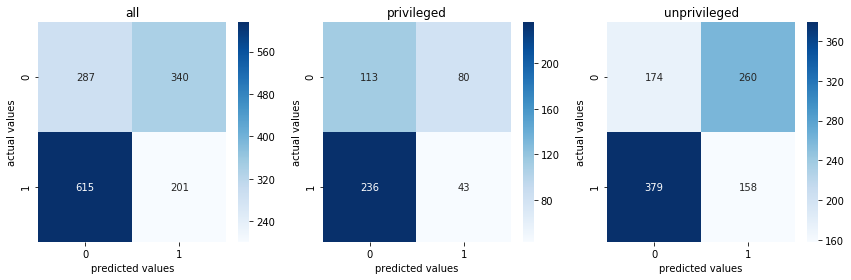

In [7]:
import matplotlib.pyplot as plt
from utils import plot_confusion_matrix_by_group

fig = plot_confusion_matrix_by_group(clf_metric, figsize=(12,4))
plt.tight_layout()
plt.show()

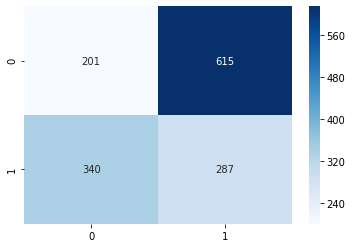

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test['two_year_recid'], test['compas_class'])
sns.heatmap(cm, annot=True, cmap=plt.get_cmap('Blues'), fmt='g')

### Questions

- Why aif360 confusion matrix is flipped?
- 

## Performance metrics by group

In [9]:
print(clf_metric.performance_measures(privileged=True))
print(clf_metric.performance_measures(privileged=False))
print(clf_metric.performance_measures(privileged=None))

{'TPR': 0.15412186379928317, 'TNR': 0.5854922279792746, 'FPR': 0.41450777202072536, 'FNR': 0.8458781362007168, 'GTPR': 0.15412186379928317, 'GTNR': 0.5854922279792746, 'GFPR': 0.41450777202072536, 'GFNR': 0.8458781362007168, 'PPV': 0.34959349593495936, 'NPV': 0.3237822349570201, 'FDR': 0.6504065040650406, 'FOR': 0.6762177650429799, 'ACC': 0.3305084745762712}
{'TPR': 0.2942271880819367, 'TNR': 0.4009216589861751, 'FPR': 0.5990783410138248, 'FNR': 0.7057728119180633, 'GTPR': 0.2942271880819367, 'GTNR': 0.4009216589861751, 'GFPR': 0.5990783410138248, 'GFNR': 0.7057728119180633, 'PPV': 0.37799043062200954, 'NPV': 0.31464737793851716, 'FDR': 0.6220095693779905, 'FOR': 0.6853526220614828, 'ACC': 0.3419155509783728}
{'TPR': 0.24632352941176472, 'TNR': 0.45773524720893144, 'FPR': 0.5422647527910686, 'FNR': 0.7536764705882353, 'GTPR': 0.24632352941176472, 'GTNR': 0.45773524720893144, 'GFPR': 0.5422647527910686, 'GFNR': 0.7536764705882353, 'PPV': 0.37153419593345655, 'NPV': 0.3181818181818182, '

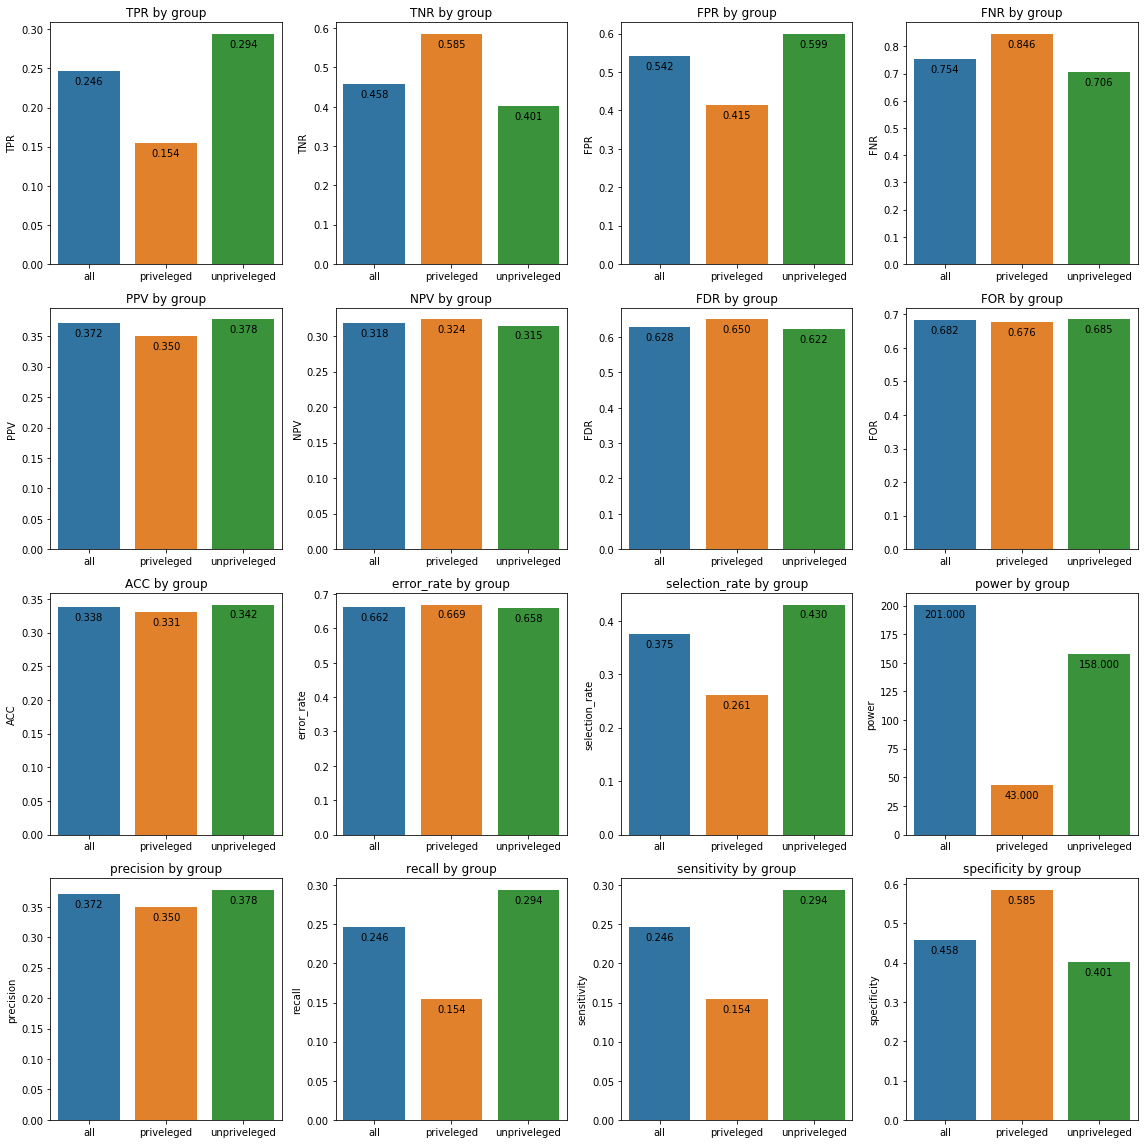

In [10]:
from utils import plot_performance_by_group

group_metrics = ['TPR', 'TNR', 'FPR', 'FNR', 'PPV', 'NPV', 'FDR', 'FOR', 
                 'ACC', 'error_rate', 'selection_rate', 'power',
                 'precision', 'recall', 'sensitivity', 'specificity', 
                ]

fig, axs = plt.subplots(4,4,figsize=(16,16))
for i, metric in enumerate(group_metrics):
    plot_performance_by_group(clf_metric, metric, axs[i//4,i%4])
    plt.tight_layout()

## Difference

**Unprivileged - Priviliged**

In [11]:
print(clf_metric.true_positive_rate_difference())
print(clf_metric.false_positive_rate_difference())
print(clf_metric.false_negative_rate_difference())
print(clf_metric.false_omission_rate_difference())
print(clf_metric.false_discovery_rate_difference())
print(clf_metric.error_rate_difference())
print(clf_metric.average_odds_difference())

0.14010532428265354
0.18457056899309948
-0.14010532428265354
0.009134857018502918
-0.02839693468705018
-0.01140707640210159
0.1623379466378765


## Ratio

**Unprivileged / Priviliged**

In [12]:
print(clf_metric.false_positive_rate_ratio())
print(clf_metric.false_negative_rate_ratio())
print(clf_metric.false_omission_rate_ratio())
print(clf_metric.false_discovery_rate_ratio())
print(clf_metric.error_rate_ratio())

1.4452764976958525
0.8343670106997443
1.0135087504214302
0.9563397129186604
0.9829615820829368


### Questions

- Which group has higher FPR, FNR, Recall, Precision?
- Is this model fair? If not why?

## Fairness metrics

### Disparate impact & Statistical parity

- Disparate impact: Ratio of selection rates. 
- Statistical parity: Difference of selection rates. 

Disparity between how often members of the unprivileged/privileged groups get impacted.

In [13]:
print(clf_metric.disparate_impact())
print(clf_metric.statistical_parity_difference())

1.6519387438982525
0.16989081673619716


### Questions

- Which group is affected negatively?
- Is it fair?

### Equal opportunity

Difference between True Positive Rates.

Model should give equal opportunity by selecting members at the same TPR for each group.

In [14]:
print(clf_metric.equal_opportunity_difference())

0.14010532428265354


### Entropy index

**THIS SHOULD WORK ON SCORES!!!***

- Originaly proposed to measure income inequality
- In the case of classification, closely related to accuracy (y_true - y_pred in the formulas)
- Theil index alpha = 1
- Coefficient of variation alpha = 2
- The closer to 0 the better
- between_group and between_all_groups are interesting for fairness
- Can generalize to multiclass labels
- Can deal with individual fairness

[Read a paper by Till Speicher and others](https://arxiv.org/pdf/1807.00787.pdf)

In [15]:
print(clf_metric.generalized_entropy_index())
print(clf_metric.between_group_generalized_entropy_index())
print(clf_metric.between_all_groups_generalized_entropy_index())

print(clf_metric.coefficient_of_variation())
print(clf_metric.between_group_coefficient_of_variation())
print(clf_metric.between_all_groups_coefficient_of_variation())

print(clf_metric.theil_index())
print(clf_metric.between_group_theil_index())
print(clf_metric.between_all_groups_theil_index())

0.47735562488271716
0.007264099804988049
0.019451975024413495
1.3818185479761331
0.17045937703732286
0.27894067487129587
0.6149759868075845
0.0075090922374083284
0.019913894458383423


### Questions

- Individual fairness vs accuracy, what is the difference?
- Which metrics should we care about for this problem?

# Log fairness metrics

In [6]:
import neptune
from neptunecontrib.api.utils import get_filepaths

neptune.init('jakub-czakon/model-fairness')
neptune.create_experiment(name='compas',tags=['compas', 'race'],
                          upload_source_files=get_filepaths(extensions=['.py','.ipynb']))

neptune.log_metric('roc_auc',roc_auc)
log_fairness_metrics(clf_metric)

neptune.stop()

https://ui.neptune.ml/jakub-czakon/model-fairness/e/MOD-79
